In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from functools import partial
from itertools import combinations
from copy import deepcopy
from toolz import compose, valmap, keyfilter, identity
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats as stats

import seaborn as sns
import pandas as pd

import sbi
import sbi.utils
import sbi.inference
import sbi.analysis
import sbibm

import swyft
import swyft.utils.constrainedcorner as cc

import tmnre
import tmnre.metrics
import tmnre.benchmark
import tmnre.coverage.oned
from tmnre.nn.resnet import make_resenet_tail
from tmnre.marginalize import filter_marginals_by_dim

In [3]:
def get_10k(x):
    return np.random.permutation(x)[:10000, ...]

def get_xmany(x):
    def getthem(y):
        return np.random.permutation(y)[:x, ...]
    return getthem

In [4]:
log = logging.getLogger()
log.setLevel(logging.INFO)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

np.random.seed(27);
torch.manual_seed(27);

In [5]:
TASK_NAME = "torus"
task = sbibm.get_task(
    TASK_NAME,
)

NUM_OBS = 1
NINIT = 5_000
N_POSTERIOR_SAMPLES = 50_000
MAX_ROUNDS = 10
SIMKEY = "x"
DEVICE = torch.device('cuda:1')

theta0 = task.get_true_parameters(NUM_OBS).squeeze()
obs0 = task.get_observation(NUM_OBS).squeeze()
print(theta0)
print(obs0)

tensor([0.5700, 0.8000, 1.0000])
tensor([0.5700, 0.0300, 1.0000])


In [6]:
backup = ""
# backup = "backup/"

In [7]:
samples_path = f"{backup}torus-samples.pickle"
focused_prefix = "focused/nsims-"
unfocused_prefix = "unfocused/nsims-"
focused_rejection_prefix = "rej-focused/nsims-"
unfocused_rejection_prefix = "rej-unfocused/nsims-"
with open(samples_path, "rb") as f:
    payload = pickle.load(f)
n_simulations = payload["n_simulations"]
focused_samples = [payload[focused_prefix + str(n)] for n in n_simulations]
unfocused_samples = [payload[unfocused_prefix + str(n)] for n in n_simulations]
focused_rejection_samples = [payload[focused_rejection_prefix + str(n)] for n in n_simulations]
unfocused_rejection_samples = [payload[unfocused_rejection_prefix + str(n)] for n in n_simulations]

In [8]:
path = f"{backup}torus-ref.pickle"
with open(path, "rb") as f:
    reference_samples, ref_marginals = pickle.load(f)

In [9]:
path = f"{backup}torus-bounds-volumes.pickle"
with open(path, "rb") as f:
    bounds, volumes = pickle.load(f)

In [10]:
path = f"{backup}torus-amortized-c2sts.pickle"
with open(path, "rb") as f:
    focused_amortized_c2sts, unfocused_amortized_c2sts = pickle.load(f)

In [11]:
path = f"{backup}torus-c2sts.pickle"
with open(path, "rb") as f:
    focused_c2sts, unfocused_c2sts = pickle.load(f)

In [12]:
def get_summary_kld(samples, ref_samples, limits=(0.0, 1.0), bins=100, add_a_sample=True):
    task_limits = np.ones((task.dim_parameters, 2)) * limits
    doit = partial(
        tmnre.metrics.kl.kl_summary_swyft,
        ref_samples=ref_samples,
        task_limits=task_limits,
        dim=1,
        bins=bins,
        add_a_sample=add_a_sample,
    )
    return [sum(doit(swyft_samples=s).values()) for s in samples]
#     return [doit(swyft_samples=s).values() for s in samples]

focused_klds = get_summary_kld(focused_samples, reference_samples)

unfocused_samples_fixed = deepcopy(unfocused_samples)
for s in unfocused_samples_fixed:
    s['weights'] = valmap(lambda x: x + 1e-16, s['weights'])
unfocused_klds = get_summary_kld(unfocused_samples_fixed, reference_samples)

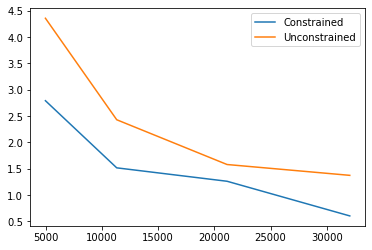

In [13]:
fig, ax = plt.subplots()
ax.plot(n_simulations, torch.tensor(focused_klds).numpy(), label="Constrained")
ax.plot(n_simulations, torch.tensor(unfocused_klds).numpy(), label="Unconstrained")
# ax.set_yscale("log")
ax.legend()

Text(0.5, 0, 'n simulations')

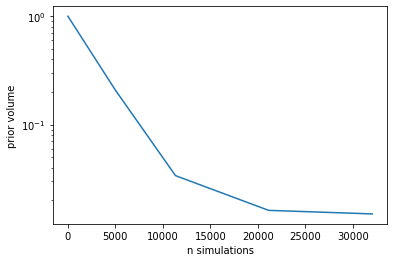

In [14]:
fig, axes = plt.subplots()
axes.plot([0] + n_simulations, volumes)
axes.set_yscale('log')
axes.set_ylabel("prior volume")
axes.set_xlabel("n simulations")
# fig.savefig("figures/volume.pdf")

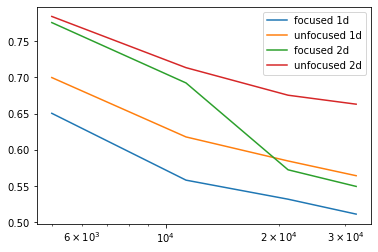

In [15]:
fig, ax = plt.subplots()
get_1d_mean = lambda x: torch.tensor([i['1-dim mean'] for i in x]).numpy()
get_2d_mean = lambda x: torch.tensor([i['2-dim mean'] for i in x]).numpy()

ax.plot(n_simulations, get_1d_mean(focused_c2sts), label="focused 1d")
ax.plot(n_simulations, get_1d_mean(unfocused_c2sts), label="unfocused 1d")
ax.plot(n_simulations, get_2d_mean(focused_c2sts), label="focused 2d")
ax.plot(n_simulations, get_2d_mean(unfocused_c2sts), label="unfocused 2d")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

### Show the cutoff

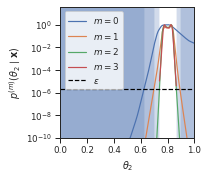

In [16]:
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")

mul = 1.75
height = mul * 1.375
width = mul * 1.375

fig, ax = plt.subplots(figsize=(width, height))
alpha = 0.25

fs = focused_samples[-3]
for i, fs in enumerate(focused_samples):
    theta, r = swyft.utils.wmutils.get_params_weights_from_weighted_marginals(fs, 1)
    inds_sorted = np.argsort(theta.flatten())
    theta_sorted, r_sorted = theta[inds_sorted], r[inds_sorted]
    ax.plot(
        theta_sorted, 
        r_sorted / r_sorted.max(),
#         label="$\hat{r}_{2}^{(" + str(i) + r")}(\mathbf{x} \mid \theta_{2})$",
#         label=r"$\frac{\hat{r}_{2}^{(" + str(i) + r")}(\mathbf{x} \mid \theta_{2})}{\max_{\theta_2}(\hat{r}_{2})}$",
        label=f"$m={i}$",
    )

# ax.set_ylabel(r"$\hat{r}_{2}^{(m)}(\mathbf{x} \mid \theta_{2}) \; / \; \max_{\theta_2}(\hat{r}_{2}^{(m)}(\mathbf{x} \mid \theta_{2}))$")
ax.set_ylabel(r"$p^{(m)}(\theta_{2} \mid \mathbf{x})$")
ax.set_xlabel(r"$\theta_{2}$")
# epsilon
ax.axhline(
    np.exp(-13), 
    color="black", 
    label="$\epsilon$",
    linestyle="--"
)

ax.set_yscale("log")
ax.set_xlim(0, 1)
ylim = ax.get_ylim()
ax.set_ylim(10 ** -10, ylim[1])

# region
xlim = ax.get_xlim()
for bound in bounds:
    bound = bound[1, :]
    ax.axvspan(xlim[0], bound[0], alpha=alpha)
    ax.axvspan(bound[1], xlim[1], alpha=alpha)

ax.legend(
    ncol=1,
    loc="best",
#     fontsize="large",
)
fig.savefig("figures/torus-1d-conceptual.png", bbox_inches="tight")

### coverage test

0
1
2


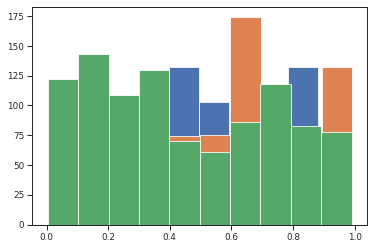

In [17]:
path = "torus-covfs.npz"
with open(path, "rb") as f:
    covfs = np.load(path)
for d, v in covfs.items():
    print(d)
    plt.hist(v.flatten())

In [18]:
toplot = {}
for k, relevant_covfs in covfs.items():
    ccount = stats.cumfreq(1-relevant_covfs.flatten(), numbins = 100).cumcount
    ccount /= ccount.max()
#     ccount_err = np.sqrt(ccount*ccount*(1-ccount))
    toplot[k] = ccount

0.70288 0.9395499999999998
0.6966399999999999 0.9402499999999999
0.60848 0.9557499999999998


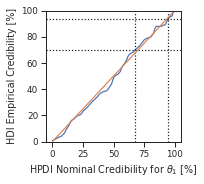

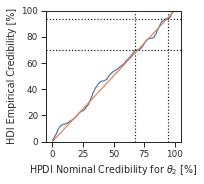

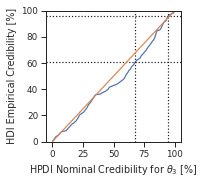

In [19]:
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")

for k, ccount in toplot.items():
    fig, ax = plt.subplots(figsize = (width, height))
    ax.plot(np.linspace(0, 100, len(ccount)), ccount*100)
    #plt.plot(np.linspace(0, 100, len(ccount)), (ccount+ccount_err)*100)
    ax.set_ylim([0, 100])
    f68 = np.interp(0.68, np.linspace(0, 1, len(ccount)), ccount)
    f95 = np.interp(0.95, np.linspace(0, 1, len(ccount)), ccount)
    ax.axvline(68, color='k', ls=':')
    ax.axvline(95, color='k', ls=':')
    ax.axhline(f68*100, color='k', ls=':')
    ax.axhline(f95*100, color='k', ls=':')
    ax.set_xlabel("HPDI Nominal Credibility for " + r"$\theta" + f"_{int(k) + 1}$ [%]")
    ax.plot([0, 100], [0, 100])
    ax.set_ylabel("HDI Empirical Credibility [%]")
    print(f68, f95)
    fig.savefig(f"figures/torus-ci-{int(k)+1}.png", bbox_inches="tight")

### New versions of metric and epsilon

In [20]:
print(n_simulations)

[4985, 11322, 21127, 32032]


In [21]:
budget_name = r"$N_{simulation}$"
kld_name = "Sum KL"
c2st_name = "C2ST-ddm"
dim_name = "Dimension"
method_name = "Method"
volume_name = "Prior Volume"

def zip_with_nsims(x):
    return list(zip(*x, n_simulations))

def get_c2st_data():
    get_1d_mean = lambda x: torch.cat([i['1-dim mean'] for i in x]).flatten().numpy()
    get_2d_mean = lambda x: torch.cat([i['2-dim mean'] for i in x]).flatten().numpy()
    c2sts = np.asarray([get_1d_mean(focused_c2sts), get_1d_mean(unfocused_c2sts), get_2d_mean(focused_c2sts), get_2d_mean(unfocused_c2sts)])
    columns = ["1-dim TMNRE", "1-dim MNRE", "2-dim TMNRE", "2-dim MNRE", budget_name]
    data = pd.DataFrame(zip_with_nsims(c2sts), columns=columns)
    data = data.melt(id_vars=budget_name, var_name=method_name, value_name=c2st_name)
    data[dim_name] = data[method_name].map(lambda x: x.split()[0])
    data[method_name] = data[method_name].map(lambda x: x.split()[1])
    return data

def get_volume_data():
    vs = volumes[1:]
    data = pd.DataFrame(np.asarray([n_simulations, vs]).T, columns=[budget_name, volume_name])
    data[method_name] = ["TMNRE"] * len(data)
    
    rows = []
    for _, n in zip(volumes, n_simulations):
        row = {method_name: ["MNRE"], budget_name: [n], volume_name: [1.0]}
        rows.append(pd.DataFrame.from_dict(row))
    addon = pd.concat(rows, ignore_index=True)
    return pd.concat([data, addon], ignore_index=True)

def get_kld_data():
    klds = torch.tensor([focused_klds, unfocused_klds]).numpy()
    columns = [r"1-dim TMNRE$", r"1-dim MNRE$", budget_name]
    data = pd.DataFrame(zip_with_nsims(klds), columns=columns)
    data = data.melt(id_vars=budget_name, var_name=method_name, value_name=kld_name)
    data[dim_name] = data[method_name].map(lambda x: x.split()[0])
    data[method_name] = data[method_name].map(lambda x: x.split()[1])
    return data

No handles with labels found to put in legend.


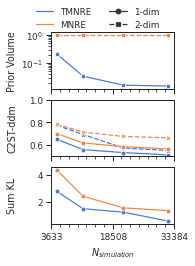

In [22]:
mul = 1.6
width = mul * 5.5 / 4
height = width * 1.6

sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")

figsize = (width, height)
fig, axes = plt.subplots(nrows=3, figsize=figsize, sharex=True)

g = sns.lineplot(
    data=get_volume_data(), 
    x=budget_name, 
    y=volume_name,  
    hue=method_name, 
    style=method_name, 
    ax=axes[0],
    palette="muted",
    markers=["s", "s"],
    legend="brief",
)
ylim = g._axes.get_ylim()
# g._axes.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
# g._axes.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.01))
# g._axes.locator_params(axis='y', tight=True, nbins=10)
g._axes.set_yscale("log")
g._axes.legend(
    frameon=False, 
    loc=(0.02, 0.55)
)
handles_vol, labels_vol = g._axes.get_legend_handles_labels()
g.legend().remove()

kwargs = dict(
    palette="muted",
    markers=True,
)

g = sns.lineplot(
    data=get_c2st_data(), 
    x=budget_name, 
    y=c2st_name, 
    hue=method_name, 
    style=dim_name, 
    ax=axes[1],
    legend="full",
    **kwargs,
)
g._axes.set_ylim(0.5, 1.0)
handles, labels = g._axes.get_legend_handles_labels()
g.legend().remove()
# axes[1].legend(handles[1:3], labels[1:3], loc="upper right", frameon=False)

g = sns.lineplot(
    data=get_kld_data(), 
    x=budget_name, 
    y=kld_name, 
    hue=method_name, 
    style=dim_name, 
    ax=axes[2],
    legend=False,
    **kwargs,
)
# axes[2].legend(handles[4:], labels[4:], loc="upper right", frameon=False)
g.legend().remove()
ax = g._axes
start, stop = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, stop, num=3))
# ax.xaxis.set_major_formatter('{x:1.1e}')
ax.xaxis.set_ticks(np.linspace(start, stop, num=15), minor=True)


for ax in axes:
    ax.tick_params(
        axis="both",
        which="both",
#         labelsize="x-small"
    )

# add handles and labels
fig.legend(
    handles[1:3] + handles[4:],
    labels[1:3] + labels[4:], 
    ncol=2,
    loc="upper center", 
    frameon=False,
#     fontsize="small",
)

fig.align_labels()
fig.savefig("figures/torus-metrics.png", bbox_inches='tight')

### posteriors and epsilon

In [23]:
mul = 1.75
square = mul * 5.5 / 4 

truth = theta0.flatten().clone().numpy()
truth[-1] -= 0.018

kwargs = dict(
    kde=True,
    bins=75,
    figsize=(square, square),
    space_between_axes=0.25,
    truth=truth,
    ticks=True,
    ticklabels=True,
    ticklabelsize="small",
    labels=[r"$\theta_{" + str(i) + "}$" for i in range(1, task.dim_parameters + 1)],
    labelrotation=50,
)

fittext_kwargs = dict(
    y=0.8,
    fontsize="x-large",
)

In [24]:
df = pd.read_csv("../epsilon/epsilon-results.csv", index_col=0)
df["1-dim"] = df["1-dim mean"] / df["num_simulations"]
df["2-dim"] = df["2-dim mean"] / df["num_simulations"]
data = df[["epsilon", "num_simulations", "1-dim", "2-dim"]].melt(
    id_vars=["epsilon", "num_simulations"], 
    var_name="dim", 
    value_name="c2st"
)

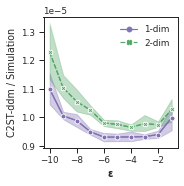

In [25]:
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")
sns.color_palette(None, 3)

fig, ax = plt.subplots(figsize=(square, square))

epsilon_kwargs = dict(
    hue="dim", 
    style="dim", 
    ax=ax,
#     palette="muted",
    palette=["m", "g"],
    markers=True,
)

sns.lineplot(
    data=data, 
    x='epsilon', 
    y="c2st",
    legend="brief",
    **epsilon_kwargs,
)
sns.lineplot(
    data=data, 
    x='epsilon', 
    y="c2st",
    legend=False,
    **epsilon_kwargs,
)
ax = plt.gca()
ax.set_ylabel("C2ST-ddm / Simulation")
ax.set_xlabel(r"$\mathbf{\epsilon}$")
ax.legend(
    frameon=False,
)
fig.savefig("figures/torus-epsilon.png", bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:36<00:00, 12.04s/it]


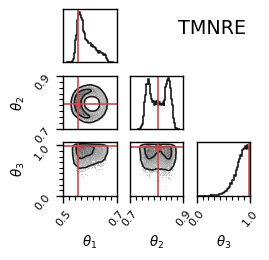

In [26]:
matplotlib.rc_file_defaults()
sns.set_context("paper")

fs = valmap(
    get_xmany(30000), 
    focused_rejection_samples[-1]
)
dfs = swyft.utils.get_df_dict_from_marginals(fs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
ya, yb = axes[2, 0].get_ylim()
axes[2, 0].set_ylim(0.0, yb)

xa, xb = axes[2, 2].get_xlim()
axes[2, 2].set_xlim(0.0, 1.0)

for ax in axes[1:, 0]:
    start, stop = ax.get_ylim()
    stop = stop if stop <= 1.0 else 1.0
    ax.yaxis.set_ticks(np.linspace(start, stop, num=2))
    ax.yaxis.set_major_formatter('{x:0.1f}')
    ax.yaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)

for ax in axes[2, :]:
    start, stop = ax.get_xlim()
    ax.xaxis.set_ticks(np.linspace(start, stop, num=2))
    ax.xaxis.set_major_formatter('{x:0.1f}')
    ax.xaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)

plt.figtext(
    s="TMNRE",
    x=0.6,
    **fittext_kwargs,
)

# fig.savefig("figures/torus-tmnre-corner.pdf", bbox_inches='tight')
fig.savefig("figures/torus-tmnre-corner.png", bbox_inches='tight', dpi=300)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:38<00:00, 12.95s/it]


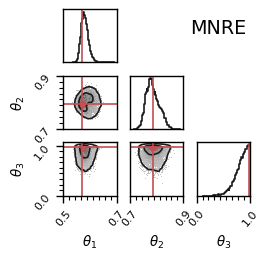

In [27]:
matplotlib.rc_file_defaults()
sns.set_context("paper")

fs = valmap(
    get_xmany(30000), 
    unfocused_rejection_samples[-1]
)
dfs = swyft.utils.get_df_dict_from_marginals(fs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
ya, yb = axes[2, 0].get_ylim()
axes[2, 0].set_ylim(0.0, yb)

xa, xb = axes[2, 2].get_xlim()
axes[2, 2].set_xlim(0.0, 1.0)

for ax in axes[1:, 0]:
    start, stop = ax.get_ylim()
    stop = stop if stop <= 1.0 else 1.0
    ax.yaxis.set_ticks(np.linspace(start, stop, num=2))
    ax.yaxis.set_major_formatter('{x:0.1f}')
    ax.yaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)

for ax in axes[2, :]:
    start, stop = ax.get_xlim()
    ax.xaxis.set_ticks(np.linspace(start, stop, num=2))
    ax.xaxis.set_major_formatter('{x:0.1f}')
    ax.xaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)

plt.figtext(
    s="MNRE",
    x=0.65,
    **fittext_kwargs,
)
    
fig.savefig("figures/torus-mnre-corner.png", bbox_inches='tight', dpi=300)

In [28]:
refs = task._sample_reference_posterior(num_samples=30_000, num_observation=1)
refs = tmnre.marginalize.all_marginals(refs.numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.60s/it]


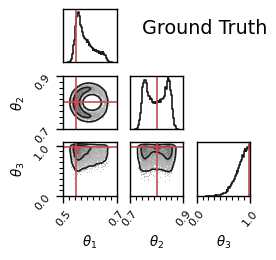

In [29]:
matplotlib.rc_file_defaults()
sns.set_context("paper")

fs = valmap(
    get_xmany(30000), 
    refs
)
dfs = swyft.utils.get_df_dict_from_marginals(fs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
ya, yb = axes[2, 0].get_ylim()
axes[2, 0].set_ylim(0.0, yb)

xa, xb = axes[2, 2].get_xlim()
axes[2, 2].set_xlim(0.0, 1.0)

for ax in axes[1:, 0]:
    start, stop = ax.get_ylim()
    stop = stop if stop <= 1.0 else 1.0
    ax.yaxis.set_ticks(np.linspace(start, stop, num=2))
    ax.yaxis.set_major_formatter('{x:0.1f}')
    ax.yaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)

for ax in axes[2, :]:
    start, stop = ax.get_xlim()
    ax.xaxis.set_ticks(np.linspace(start, stop, num=2))
    ax.xaxis.set_major_formatter('{x:0.1f}')
    ax.xaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)

plt.figtext(
    s="Ground Truth",
    x=0.45,
    **fittext_kwargs,
)
    
fig.savefig("figures/torus-ref-corner.png", bbox_inches='tight', dpi=300)